# Lab 6: How AdaBoost combines weak classifiers

In this lab you'll train an AdaBoost classifier, and inspect it to learn how it makes predictions.

The goal is to get a sense for how a several estimators can be summed together to make a strong predictor. In a random forest, each estimator is trained independently before averaging. In boosting, the estimators are trained sequentially, with each new estimator asked to "correct" mistakes made by the collection of previous estimators.

You will see that each estimator is a very simple decision tree, also called a "decision stump" because it only has one split (*max_depth=1*). The use of shallow trees is deliberate: their shallowness makes them individually 'weak' at predicting, but easier to combine (to "boost") into a strong predictor.

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree        # For DecisionTreeClassifier class
import sklearn.ensemble    # For AdaBoostClassifier class
import sklearn.datasets    # For make_gaussian_quantiles
import sklearn.metrics     # For accuracy_score

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Understanding how AdaBoost makes predictions

Exercises 1.1&ndash;1.2 ask you to train scikit-learn's AdaBoost classifier (**[sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)**) and to inspect the way it makes predictions.

**Run the code cell below** to define some useful functions for plotting data and predictions. These are the same functions used for plotting in Lab 5.

In [2]:
def plot_data(X, y):
    """Plots a toy 2D data set. Assumes values in range [-3,3] and at most 3 classes."""
    plt.plot(X[y==0,0], X[y==0,1], 'ro', markersize=6)
    plt.plot(X[y==1,0], X[y==1,1], 'bs', markersize=6)
    plt.plot(X[y==2,0], X[y==2,1], 'gx', markersize=6, markeredgewidth=2)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.gca().set_aspect('equal')
    
def plot_predict(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    If argument is already a Numpy array, treats it as predictions.
    Otherwise calls the argument's predict() function to generate predictions.
    Assumes at most 3 classes.
    """
    extent = (-3, 3, -3, 3)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')
    
def plot_class_probability(model, class_index):
    """
    Plots the model's class probability for the given class {0,1,2}
    over all points in range 2D [-3, 3]. Assumes at most 3 classes.
    """
    extent = (-3, 3, -3, 3)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    p = model.predict_proba(X)[:,class_index].reshape(x1.shape)
    colors = [[1, 0, 0], [0, 0, 1], [0, 1, 0]]
    cmap = matplotlib.colors.ListedColormap(np.linspace([1, 1, 1], colors[class_index], 50))
    plt.imshow(p, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=1, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')    

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Compare an AdaBoost classifier to a simple decision tree

The goal of this exercise is to show you that with multiple shallow "decision stumps" we can still produce the same output as single deep decision tree. Start by training a decision tree classifier like you did in Lab5. (No boosting yet.)

**Step 1: Train a decision tree classifier like you did in exercise 1.1 from Lab5.** 

**Write a few lines of code** to:

1. Build the small 2D training set below:

$$
X = \begin{bmatrix}
-1 & 0\\
-\frac{1}{3} & 0\\
\frac{1}{3} & 0\\
 1 & 0
\end{bmatrix},
\quad
y = \begin{bmatrix}
0\\
1\\
0\\
1
\end{bmatrix}
$$

2. Train a decision tree classifier on $X$ and $y$. Use argument *random_state*=0.
3. Plot the decision tree predictions and the data (use *plot_predict* and *plot_data* from preamble).
4. Plot the decision tree in a second figure (use **[sklearn.tree.plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)**); pass `feature_names=['x1', 'x2']` as an argument.

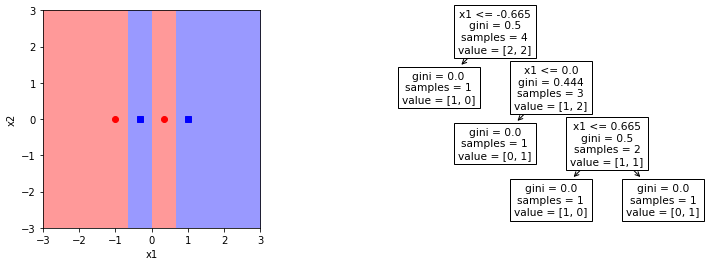

In [3]:
from sklearn import tree

X = np.array([[-1, 0],[-0.33, 0],[0.33, 0],[1, 0]])
y = np.array([0, 1, 0, 1])
clf = sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X,y)
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plot_data(X, y)
plot_predict(clf)
plt.subplot(1,2,2)
tree.plot_tree(clf,feature_names=['x1', 'x2'])
plt.show();
# Your code here. Aim for 8-12 lines.

Having already completed Lab5, you should understand exactly what you see above, i.e., how the decision tree thresholds, and the leaves, determine the red/blue regions plotted in feature space. You know from lecture that the training accuracy of a decision tree classifier is improved by "splitting" a leaf.

**Step 2: Train an *AdaBoostClassifier* on the same data.**

AdaBoost does not try to improve training accuracy by adding complexity to the current tree. In fact, each tree that AdaBoost builds only has one split (*max_depth*=1), so it is hardly a tree at all. Such a 'weak' tree is often called a "decision stump" instead of "decision tree."

Here you will train an AdaBoost classifier and see how it combines these 'stumps' to give a result comparable to the decision tree you trained. The decision stumps of an AdaBoostClassifier object are available via the *estimators_* attribute, which is a list of *DecisionTreeClassifier* objects.


**Write a few lines of code** to:
1. Train an **[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)** on the same data set. Use *n_estimators*=3 as an argument when building your classifier in order to keep it simple enough to inspect closely. Specify *algorithm*='SAMME' to use a more classical variant of AdaBoost that more closely aligns with what you will learn in class. Use *random_state*=0 for reproducibility.
2. Plot the decision regions and data like you did for the decision tree.
3. Plot the tree structure of each decision stump in a separate figure. Use *sklearn.tree.plot_tree*.

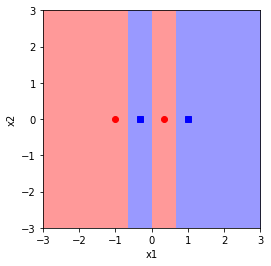

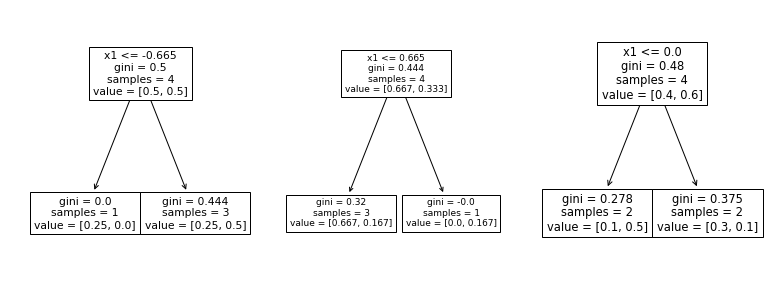

In [4]:
clf_Ada = sklearn.ensemble.AdaBoostClassifier(n_estimators=3,algorithm='SAMME',random_state=0).fit(X,y)
plot_data(X, y)
plot_predict(clf_Ada)
plt.figure(figsize=(13,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    tree.plot_tree(clf_Ada.estimators_[i],feature_names=['x1', 'x2'])
# Your code here. Aim for 4-6 lines.

Now you have now trained an AdaBoost classifier and should see that it generates the same predictions as your original decision tree.

**Step 3: Plot the individual decision stumps of your boosted ensemble**

Finally, you should inspect the individual decision 'stumps' that AdaBoost is using to generate its predictions. You should generate three figures (one for each stump, of which there are *n_estimators*). Each figure should have two subplots: on the left plot decision regions of the stump along with the training data, and on the right plot the split that the stump uses to predict class labels. Your first figure should like this:

![image](img/adaboost-simple-stump-0.png)

Each decision stump (each estimator) has a weight associated with it. This is the weight the model is given when making predictions. Find the weight using the *estimator_weights_* attribute of the AdaBoostClassifier and include the weight as part of the title, as shown above.

**Write plotting code** below. There should be one plot per estimator in your trained *AdaBoostClassifier* object. The i<sup>th</sup> plot should have two subplots side-by-side: (1) the decision regions of the i<sup>th</sup> estimator, and (2) the decision tree (stump) for the i<sup>th</sup> estimator.

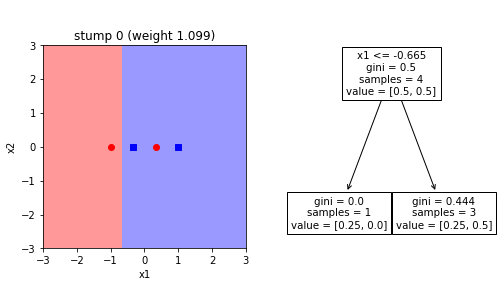

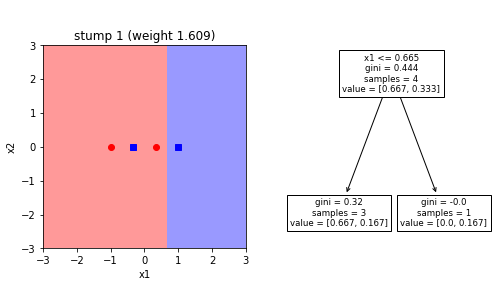

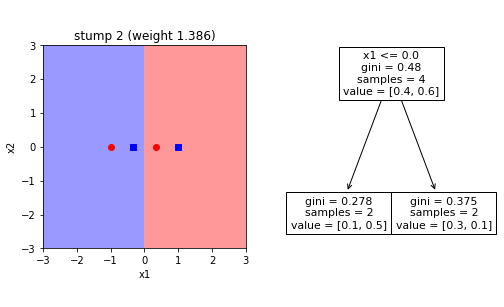

<Figure size 576x360 with 0 Axes>

In [5]:
clf_Ada = sklearn.ensemble.AdaBoostClassifier(n_estimators=3,algorithm='SAMME',random_state=0).fit(X,y)
plt.figure(figsize=(8,5))
for i in range(3):
    plt.subplot(1,2,1)
    plot_data(X, y)
    plt.title('stump '+str(i)+' (weight '+ str("%.3f" % clf_Ada.estimator_weights_[i])+')')
    plot_predict(clf_Ada.estimators_[i])
    plt.subplot(1,2,2)
    tree.plot_tree(clf_Ada.estimators_[i],feature_names=['x1', 'x2'])
    plt.figure(figsize=(8,5));
# Your code here. Aim for 8-10 lines.

The AdaBoost training procedure that led to these particular stumps will be made clear in lecture, but is not important for this lab. The rough idea behind AdaBoost training is that the $R^\text{th}$ decision stump is trained to fix the mistakes (misclassifications) that the previous decision stumps $1,\ldots,R-1$ are currently making on the training set. As long as this new decision stump can fix at least one mistake, we can continue "boosting" by adding more.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Compute an AdaBoost prediction "by hand"

The point of Exercise 1.1 was to show that complex decision regions can be built not just by deepening a decision tree, but also by (somehow) combining the predictions of decision stumps. 

Here you will learn precisely how that 'combining' happens. You will reproduce AdaBoost's predictions by writing your own code to combine the decision stump predictions.

**Run the code cell below** to define a function that will plot the training data along the $x$-axis only, using just component $x_{i1}$ of each training point $\mathbf{x}_i = (x_{i1}, x_{i2})$. For this exercise your plots will use the $y$-axis to represent the probability of class 1 (blue).

In [6]:
def plot_data_1d(X, y):
    """
    Plots just the first component of a toy 2D data set.
    Assumes values in range [-3,3] and at most 3 classes.
    """
    plt.plot([-3, 3], [0.5, 0.5], '--k', alpha=0.25)
    plt.plot(X[y==0,0], X[y==0,1]*0+0.5, 'ro', markersize=6)
    plt.plot(X[y==1,0], X[y==1,1]*0+0.5, 'bs', markersize=6)
    plt.plot(X[y==2,0], X[y==2,1]*0+0.5, 'gx', markersize=6, markeredgewidth=2)
    plt.xlim([-3, 3])
    plt.xlabel('x1')

**Step 1: Plot the prediction of each decision stump, separately.**

Before combining the decision stumps, plot the predictions of each stump as a 1-dimensional function, so that it will be easier to see how they add up.

Specifically, plot each decision stump's class prediction along the $x_1$ dimension, using the $y$-axis to show the class probability. You should generate three figures, one for each decision stump (each estimator). Your first figure should look like:
![image](img/adaboost-simple-stump-0-one-dimension.png)
Note that the green line here is not a decision boundary! We are plotting a 1-dimensional feature space, so the place where the green line crosses the $y$-axis at 0.5 is the decision boundary! The above plot corresponds to the decision region of the first decision stump you plotted in Exercise 1.1, i.e., red region to the left, blue region to the right.

**Write plotting code** to show the separate class prediction of each stump.
* Use *plot_data_1d* to plot the four training points.
* For plotting, build an array of the $x$-axis values. Specifically, use the [np.linspace](https://numpy.org/devdocs/reference/generated/numpy.linspace.html) function to create an array of $N=500$ equally-spaced $x$ values in range $[-3, 3]$.
* To generate $y$-axis values for your plot, you'll need to call the *predict* function on your already-trained *AdaBoostClassifier* object (from previous exercise). You should generate all $N$ values using a single call to predict. To do this, build an $(N,2)$ matrix $\mathbf{X}$, where the first column ($x_1$) is filled with $x$-axis values and the second column ($x_2$) is filled with zeros. Then call *predict* once.
* Once you have a single plot working, use a for-loop to generate a separate figure for each decision stump. Use the *n_estimators* attribute of your trained *AdaBoostClassifier*, rather than hard-coding 3 iterations.

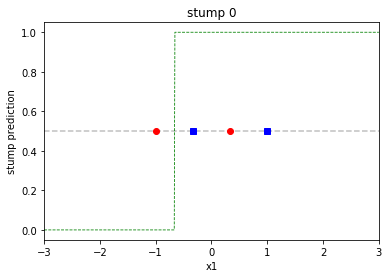

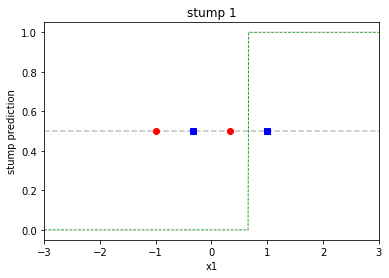

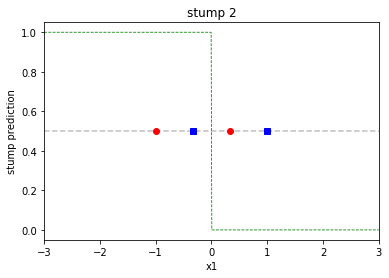

In [7]:
x = np.linspace(-3.0, 3.0, num=500).reshape(-1,1)
y0 = np.reshape(np.zeros(500),(-1,1))
x0 = np.hstack((x,y0))
for i in range(clf_Ada.n_estimators):
    plot_data_1d(X, y)
    clf = clf_Ada.estimators_[i]
    y_pred = clf.predict(x0)
    plt.plot(x,y_pred,'g--',linewidth=0.8)
    plt.title('stump '+str(i))
    plt.ylabel('stump prediction')
    plt.show();
# Your code here. Aim for 10-12 lines.

You should see that the class predictions correspond with the red/blue decision regions for each stump that you observed at the end of Exercise 1.1.

**Step 2: Plot a weighted combination of the decision stump predictions.**

Here you will plot a *weighted combination* of the individual decision stump predictions. Given an input $\mathbf{x}$, an AdaBoost classifier's decision function $y(\mathbf{x})$ is computed as a weighted combination of decision strump class predictions. Let $f_r(\mathbf{x})$ denote the $r^\text{th}$ decision stump, and $w_r$ be its weight. A prediction is then:

$$
y(\mathbf{x}) = \frac{\sum_{r=1}^R w_r f_r(\mathbf{x})}{\sum_{r=1}^R w_r} 
$$


This exercise asks you to implement the above function manually, in Numpy. In effect, you'll implement the "prediction" part of a trained AdaBoost classifier. Since the training data only varies in the first feature ($x_1$), you'll plot it over the range $x_1 \in [-3,3]$ and $x_2=0$ just like you did in the previous step.

For example, if you made an AdaBoost classifier with $R=2$ decision stumps, your plot might look something like this:

![image](img/adaboost-simple-weighted-stumps-1.png)

**Write code** to
* Compute the AdaBoost decision function formula $y(\mathbf{x})$ directly from the *estimators_* and *estimator_weights_* attributes of your already-trained AdaBoostClassifier object. You will be plotting the predictions over $x_1 \in [-3, 3]$, so you can just pass your matrix $\mathbf{X}$ from the previous step.
* Plot the $y(\mathbf{x})$ predictions.
* Plot the training data as before (*plot_1d_data*)

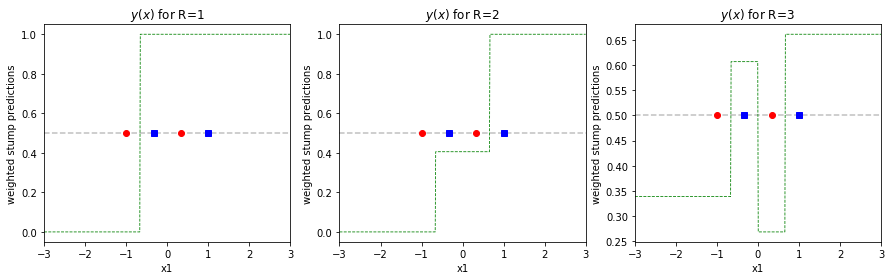

In [8]:
# Your code for computing y(x) values from the individual estimators.
def decision_function_formula(x,R):
    
    weighted_sum = 0
    sum_of_weights = 0 
    for i in range(R):
        weighted_sum += clf_Ada.estimator_weights_[i]*clf_Ada.estimators_[i].predict(x)
        sum_of_weights += clf_Ada.estimator_weights_[i]
        
    return weighted_sum/sum_of_weights, R

# Aim for 2-8 lines, and vectorize where possible.

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plot_data_1d(X, y)
y_pred,R = decision_function_formula(x0,1)
plt.plot(x0[:,0],y_pred,'g--',linewidth=0.8)
plt.ylabel('weighted stump predictions')
plt.title('$y(x)$ for R='+ str(R))
# ----------------------------------------------------------------------------------------
plt.subplot(1,3,2)
plot_data_1d(X, y)
y_pred,R = decision_function_formula(x0,2)
plt.plot(x0[:,0],y_pred,'g--',linewidth=0.8)
plt.ylabel('weighted stump predictions')
plt.title('$y(x)$ for R='+ str(R));
# ----------------------------------------------------------------------------------------
plt.subplot(1,3,3)
plot_data_1d(X, y)
y_pred,R = decision_function_formula(x0,3)
plt.plot(x0[:,0],y_pred,'g--',linewidth=0.8)
plt.ylabel('weighted stump predictions')
plt.title('$y(x)$ for R='+ str(R));

# Your plotting code here. Aim for 5-6 lines.

Finally, compare your plot above to the result of calling *decision_function* on your trained *AdaBoostClassifier* object. However, the scikit-learn *AdaBoostClassifier* implementation treats binary classification as special: it generates class predictions in range $[-1, 1]$ rather than in range $[0, 1]$. So, to get the exact same results, you may have to scale (by factor of $\frac{1}{2}$) and shift (by $+\frac{1}{2}$) the *AdaBoostClassifier*'s decision function.

**Write a few lines of code** to call *decision_function* to generate predictions over the range $x_1 \in [-3, 3]$ just as you did already. (You can re-use variables that you already defined from earlier code cells.) The plot you generate using scikit-learn should be identical to the one you generated by hand, and it should correctly classify all red and blue points in the training set.

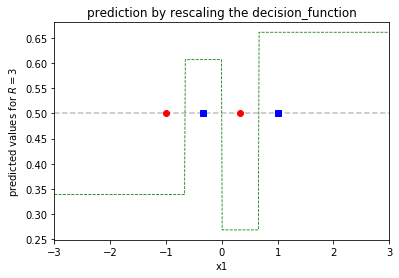

In [9]:
plot_data_1d(X, y)
y_pred = 0.5 + 0.5*clf_Ada.decision_function(x0)
plt.plot(x0[:,0],y_pred,'g--',linewidth=0.8)
plt.title('prediction by rescaling the decision_function')
plt.ylabel('predicted values for $R=3$')
plt.show()
# Your code here. Aim for 6-7 lines.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Plotting how AdaBoost increases the training accuracy

Exercises 2.1&ndash;2.2 ask you to train and inspect an AdaBoost classifier on a real data set, to see how each successive 'weak' classifier increases the overall training accuracy when weighted with the previous weak classifiers.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Create a classification dataset using scikit-learn

Here you'll create a synthetic dataset using one of scikit-learn's dataset utilities. Use the **[sklearn.datasets.make_gaussian_quantiles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_gaussian_quantiles.html)** function to generate a 2-dimensional synthetic dataset with three classes (the default).
 
**Write a few lines of code** to generate the dataset and plot it. Use *random_state*=0. Your plot should look exactly like this:
![image](img/gaussian-quantiles-data.png)

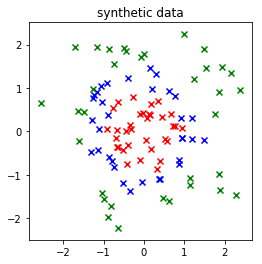

In [10]:
X, y = sklearn.datasets.make_gaussian_quantiles(random_state=0)
plt.figure(figsize=(4,4))
def plot_sync_data(X, y):
    X = np.array(list(zip(X[:,0],X[:,1],y)))
    cgp = {0:'red', 1:'blue', 2:'green'}
    for i in np.unique(X[:,2]):
        ix = np.where(y==i)
        plt.scatter(X[ix,0], X[ix,1], c = cgp[i], label = f'y = {i}',marker='x')
        plt.title('synthetic data')
plot_sync_data(X, y)
# Your code here. Aim for 6-8 lines.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Train an AdaBoost classifier on the Iris dataset and plot the decision regions

You must train an AdaBoost classifier on the synthetic training set from Exercise 2.1. Your plot should look something like this:
![image](img/gaussian-quantiles-adaboost-1.png)

**Write a few lines of code** train the classifier and plot the resulting decision regions. Use the *plot_predict* and *plot_data* functions defined at the start of the lab. Use *random_state*=0 and *algorithm*='SAMME' as before.

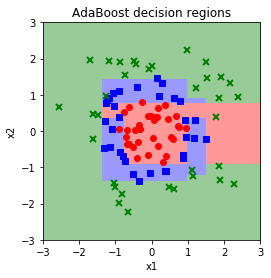

In [11]:
clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME',random_state=0).fit(X,y)
plot_data(X, y)
plot_predict(clf)
plt.title('AdaBoost decision regions')
plt.show()
# Your code here. Aim for 4-6 lines.

You may notice that the default AdaBoost hyperparameters struggle to fit this particular data. You can try playing with the *learning_rate* or *n_estimators* parameters to see how they effect the result.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.3 &mdash; Plot the decision regions of successive boosting "rounds"

You are asked to plot the decision regions of an AdaBoost classifier with *n_estimators* $\in [1, 20, 40, 60, 80, 100]$. There should be 6 plots and your first plot should look like this:

![image](img/gaussian-quantiles-adaboost-stages-1.png)

**Write a few lines of code** to generate the plots.
* Use *algorithm*='SAMME' and *random_state*=0 when training, as before.
* Use a for-loop and generate a new plot on each iteration.
* In each plot, display the *accuracy_score* on the training set in the title, as shown above.

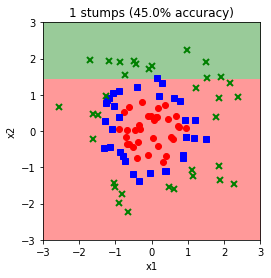

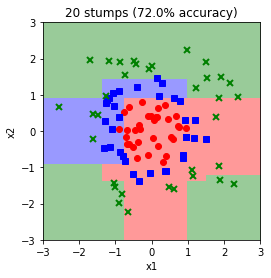

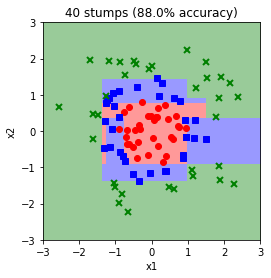

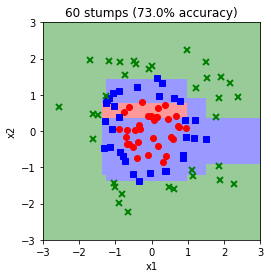

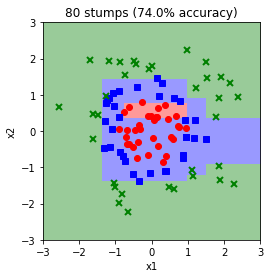

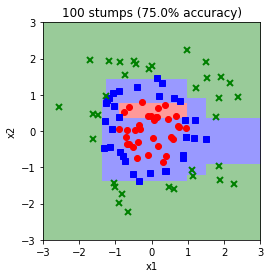

In [12]:
n_estimators = [1,20,40,60,80,100]
for i in n_estimators:
    clf = sklearn.ensemble.AdaBoostClassifier(n_estimators = i, algorithm='SAMME', random_state=0).fit(X,y)
    plot_data(X, y)
    plot_predict(clf)
    accuracy_score = clf.score(X, y) * 100
    plt.title(str(i)+ ' stumps ('+ str(accuracy_score)+'% accuracy)')
    plt.show()
# Your code here. Aim for 7-10 lines.

Notice that the accuracy fluctuates and is not particularly good even after 100 rounds of boosting.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.4 &mdash; Plot the training accuracy of successive boosting "rounds"

You are asked to plot the accuracy of an AdaBoost classifier with *n_estimators*$=1, 2, \ldots, 100$ decision stumps (estimators). This is just like Exercise 2.3 except you do not plot the decision regions, and instead keep a record of all the accuracies. Your plot should end up looking like this:

![image](img/gaussian-quantiles-adaboost-accuracy.png)

**Write a few lines of code** to generate the plot.
* Use *algorithm*='SAMME' and *random_state*=0 as before.
* Compute a list of 100 accuracies, one for each *n_estimators* setting.
* Plot the accuracies with a single call to Matplotlib's *plot* function.

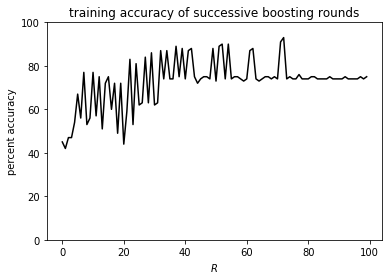

In [13]:
accuracy_score = []
x_i = np.arange(0,100)
for i in range(1,101):
    clf = sklearn.ensemble.AdaBoostClassifier(n_estimators = i, algorithm='SAMME', random_state=0).fit(X,y)
    accuracy_score += [clf.score(X, y) * 100]

plt.plot(x_i, np.array(accuracy_score), color = 'black')
plt.title('training accuracy of successive boosting rounds')
plt.xlabel('$R$')
plt.ylabel('percent accuracy')
plt.ylim((0, 100))
plt.show()
# Your code here. Aim for 9-12 lines.

Once you've got the plot working, **re-run Exercises 2.2 and 2.3 using *algorithm*="SAMME.R"** instead. Notice the training accuracy improves. The SAMME.R algorithm (R for "real numbers") is a modification of AdaBoost that builds a weighted combination of the estimators' *decision functions* (a real number), rather than a weighted combination of their *class predictions* (discrete). Scikit-learn uses SAMME.R by default.

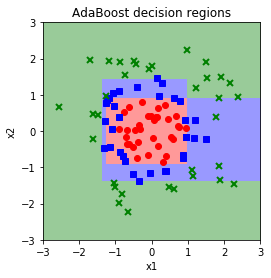

In [14]:
clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME.R',random_state=0).fit(X,y)
plot_data(X, y)
plot_predict(clf)
plt.title('AdaBoost decision regions')
plt.show()

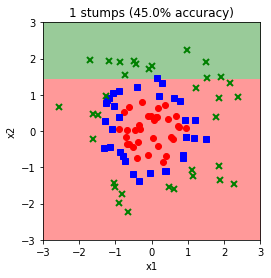

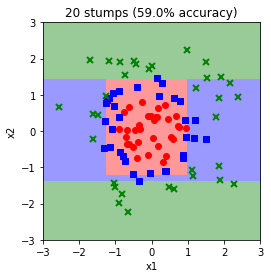

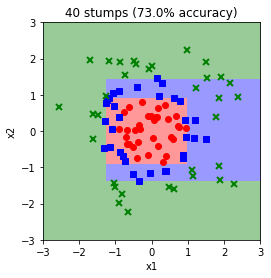

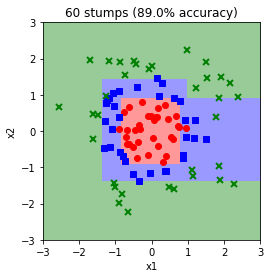

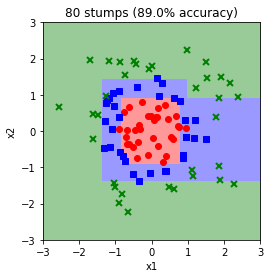

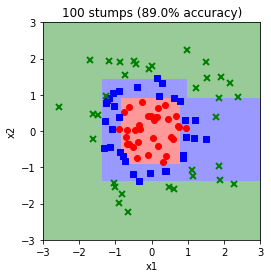

In [15]:
n_estimators = [1,20,40,60,80,100]
for i in n_estimators:
    clf = sklearn.ensemble.AdaBoostClassifier(n_estimators = i, algorithm='SAMME.R', random_state=0).fit(X,y)
    plot_data(X, y)
    plot_predict(clf)
    accuracy_score = clf.score(X, y) * 100
    plt.title(str(i)+ ' stumps ('+ str(accuracy_score)+'% accuracy)')
    plt.show()